# TME1 bandits
## imports and fetch data

In [1]:
import numpy as np

In [2]:
data = []
with open("CTR.txt", "r") as f:
    for l in f:
        ll = l.split(":")
        num = int(ll[0])
        rpz = [float(x) for x in ll[1].split(";")]
        rate = [float(x) for x in ll[2].split(";")]
        data.append((num, rpz, rate))



In [3]:
indexes = np.array([x[0] for x in data])
representations = np.array([x[1] for x in data])
rates = np.array([x[2] for x in data])

In [4]:
indexes.shape

(5000,)

In [5]:
representations.shape

(5000, 5)

In [6]:
rates.shape

(5000, 10)

In [7]:
num_ann = np.shape(rates)[1]
num_examples = np.shape(indexes)[0]
dim_rpz = representations.shape[1]

---

## scoring functions :

In [8]:
def get_scores(choices, rates=rates):    
    truth = np.argmax(rates, axis=1)
    optimal_rates = np.choose(truth, rates.T)
    # Score :
    correct_choices = np.equal(choices, truth)
    score = np.average(correct_choices, axis=0)
    # cumulative regret, cumulative reward:
    reward = np.choose(choices, rates.T)
    regret = optimal_rates - reward
    for i in indexes[1:]:
        reward[i] += reward[i-1]
        regret[i] += regret[i-1]
    return score, regret, reward
    

---

## Baselines :

In [9]:
## Stratégie Optimale

truth = np.argmax(rates, axis=1)
optimal_rates = np.choose(truth, rates.T)
score_optimal, regret_optimal, reward_optimal = get_scores(truth)
print("score_optimal = {}".format(score_optimal))

score_optimal = 1.0


In [10]:
## Stratégie Random

choices_random = np.random.randint(num_ann, size=num_examples)
score_random, regret_random, reward_random = get_scores(choices_random)
print("score_random = {}".format(score_random))


score_random = 0.0966


In [11]:
## Stratégie StaticBest

# static1 :optimisation du score
indexex_repeat = np.tile(np.arange(num_ann), (num_examples, 1))
count = np.sum(np.equal(indexex_repeat, np.tile(truth, (num_ann, 1)).T), axis=0)
choices_static1 = np.repeat(np.argmax(count), num_examples)

# static2 : optimisation du reward cumulatif
rewards_sum = np.sum(rates, axis=0)
choices_static2 = np.repeat(np.argmax(rewards_sum), num_examples)

score_static, regret_static, reward_static = get_scores(choices_static1)
print("counts = {}\nsum_rewards = {}\nchoices : static1 = {}, static2 = {}\nscore_static = {}".format(\
    count, rewards_sum, choices_static1[0], choices_static2[0], score_static))

counts = [   7  146    1 2681   13    0  243    6    0 1903]
sum_rewards = [  82.26612661  386.23033917   36.79610613 1339.63503105  162.76444454
   11.54117114  488.7300798   177.71849538   30.8446575  1229.80638244]
choices : static1 = 3, static2 = 3
score_static = 0.5362


---

## Strategies :

In [12]:
### UCB

# init :
choices_ucb = np.zeros(num_examples, np.int)-1
T_i = np.ones(num_ann, np.int)
g_i_s = np.zeros(num_ann, np.float)
for i in range(num_ann):
    g_i_s[i] += rates[i][i]
    choices_ucb[i] = i

# iter :
for t in range(num_ann, num_examples):
    mu_i = g_i_s / T_i                     # espérence empirique
    B_i = mu_i + np.sqrt(2*np.log(t)/T_i)  # Bornes sup des intervals de confiance des espérances
    pi_t  = np.argmax(B_i)                 # choix au t-ème example
    choices_ucb[t] = pi_t

# scores :
score_ucb, regret_ucb, reward_ucb = get_scores(choices_ucb)
print("score_ucb = {}".format(score_ucb))

score_ucb = 0.3794


In [13]:
### Lin-UCB

# Init:
def lin_ucb(delta=.5, alpha=None):
    if alpha is None:
        alpha = 1+np.sqrt(np.log(2/delta)/2)
        print('delta = {} -> alpha = {}'.format(delta, alpha))
    else :
        print('delta = None -> alpha = {}'.format(alpha))
    A = np.zeros((num_ann, dim_rpz, dim_rpz)) + np.identity(dim_rpz)
    b = np.zeros((num_ann, dim_rpz,1))
    choices_linucb = np.zeros(num_examples, np.int)-1
    
    # iter :
    for t in range(num_examples):
            x_t = representations[t]
            theta = np.matmul(np.linalg.inv(A), b).squeeze(-1)
            p_t = np.inner(theta, x_t) + alpha*np.sqrt(np.sum(np.outer(x_t, x_t) * np.linalg.inv(A), axis=(-1, -2)))
            a_t = np.argmax(p_t)
            r_t = rates[t, a_t]
            choices_linucb[t] = a_t
            A[a_t] += np.outer(x_t, x_t)
            b[a_t] += r_t * np.expand_dims(x_t, -1)
    return choices_linucb

# scores :
score_linucb001, regret_linucb001, reward_linucb001 = get_scores(lin_ucb(0.01))
print("score_linucb 0.01 = {}\n".format(score_linucb001))
score_linucb01, regret_linucb01, reward_linucb01 = get_scores(lin_ucb(0.1))
print("score_linucb 0.1 = {}\n".format(score_linucb01))
score_linucb05, regret_linucb05, reward_linucb05 = get_scores(lin_ucb(0.5))
print("score_linucb 0.5 = {}\n".format(score_linucb05))
score_linucb07, regret_linucb07, reward_linucb07 = get_scores(lin_ucb(0.7))
print("score_linucb 0.7 = {}\n".format(score_linucb07))
score_linucb09, regret_linucb09, reward_linucb09 = get_scores(lin_ucb(0.9))
print("score_linucb 0.9 = {}\n".format(score_linucb09))
score_linucb2, regret_linucb2, reward_linucb2 = get_scores(lin_ucb(2))
print("score_linucb 2 = {}\n".format(score_linucb2))
score_linucb_a05, regret_linucb_a05, reward_linucb_a05 = get_scores(lin_ucb(alpha=.5))
print("score_linucb a0.5 = {}\n".format(score_linucb_a05))
score_linucb_a01, regret_linucb_a01, reward_linucb_a01 = get_scores(lin_ucb(alpha=.1))
print("score_linucb a0.1 = {}\n".format(score_linucb_a01))
score_linucb_a005, regret_linucb_a005, reward_linucb_a005 = get_scores(lin_ucb(alpha=.05))
print("score_linucb a0.05 = {}\n".format(score_linucb_a005))

delta = 0.01 -> alpha = 2.6276236307187295
score_linucb 0.01 = 0.4288

delta = 0.1 -> alpha = 2.2238734153404085
score_linucb 0.1 = 0.4614

delta = 0.5 -> alpha = 1.8325546111576978
score_linucb 0.5 = 0.4946

delta = 0.7 -> alpha = 1.7245074618313732
score_linucb 0.7 = 0.505

delta = 0.9 -> alpha = 1.6318653718228955
score_linucb 0.9 = 0.5132

delta = 2 -> alpha = 1.0
score_linucb 2 = 0.5754

delta = None -> alpha = 0.5
score_linucb a0.5 = 0.6326

delta = None -> alpha = 0.1
score_linucb a0.1 = 0.6514

delta = None -> alpha = 0.05
score_linucb a0.05 = 0.5336



---

## Visualisation :

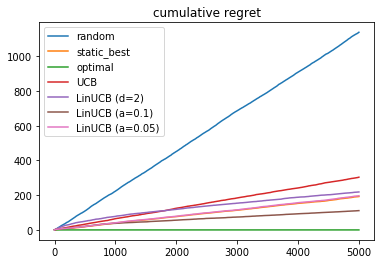

In [15]:
import matplotlib.pyplot as plt

# plt.rcParams["figure.figsize"] = (20,20)

## Display regret:
plt.title("cumulative regret")
plt.plot(indexes, regret_random, label="random")
plt.plot(indexes, regret_static, label="static_best")
plt.plot(indexes, regret_optimal, label="optimal")
plt.plot(indexes, regret_ucb, label="UCB")
#plt.plot(indexes, regret_linucb001, label="LinUCB (d=0.01)")
#plt.plot(indexes, regret_linucb01, label="LinUCB (d=0.1)")
#plt.plot(indexes, regret_linucb05, label="LinUCB (d=0.5)")
#plt.plot(indexes, regret_linucb07, label="LinUCB (d=0.7)")
#plt.plot(indexes, regret_linucb09, label="LinUCB (d=0.9)")
plt.plot(indexes, regret_linucb2, label="LinUCB (d=2)")
#plt.plot(indexes, regret_linucb_a05, label="LinUCB (a=0.5)")
plt.plot(indexes, regret_linucb_a01, label="LinUCB (a=0.1)")
plt.plot(indexes, regret_linucb_a005, label="LinUCB (a=0.05)")
plt.legend()
plt.show()

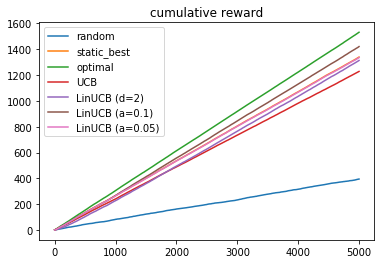

In [16]:
## Display reward:
plt.title("cumulative reward")
plt.plot(indexes, reward_random, label="random")
plt.plot(indexes, reward_static, label="static_best")
plt.plot(indexes, reward_optimal, label="optimal")
plt.plot(indexes, reward_ucb, label="UCB")
plt.plot(indexes, reward_linucb2, label="LinUCB (d=2)")
#plt.plot(indexes, reward_linucb_a05, label="LinUCB (a=0.5)")
plt.plot(indexes, reward_linucb_a01, label="LinUCB (a=0.1)")
plt.plot(indexes, reward_linucb_a005, label="LinUCB (a=0.05)")
plt.legend()
plt.show()

---

## Remarques :

On observe que `LinUCB` semble optimal sur ce problème pour une valeur de alpha proche de 0.1 (courbe grise).

Pour alpha=1 (courbe violette), on constate que `LinUCB` performe moins bien que `UCB` lors des premières itérations 
mais qu'il s'adapte et parvient à le dépasser par la suite.

Egalement on remarque que le meilleur `LinUCB` (alpha=0.1, courbe grise) dépasse `Static Best` (courbe orange), 
ce qui montre que les réponses de `LinUCB` dépendent nécessairement du contexte. 